In [1]:
import pandas as pd
from pathlib import Path

a2_df_bone_census_ol_pejeta_eastern = pd.read_pickle("../data/pkl/a2_df_bone_census_ol_pejeta_eastern.pkl")
a2_df_bone_census_ol_pejeta_eastern_rank = pd.read_pickle("../data/pkl/a2_df_bone_census_ol_pejeta_eastern_rank.pkl")
a2_df_bone_census_ol_pejeta_eastern_rank.head()

Year,1993,1996,1997,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2014,2015,2016,2017,2018,2020,2022,2023
Species,,,,,,,,,,,,,,,,,,,,,
Aepyceros melampus,3,6,2,9,4,5,2,4,3,2,...,12,7,6,4,8,3,7,8,4,3
Alcelaphus buselaphus,7,6,2,9,4,8,7,4,3,4,...,12,7,12,11,8,12,7,3,4,3
Bos taurus indicus,7,6,2,9,4,8,7,4,3,2,...,6,7,12,11,8,12,7,8,4,3
Bovidae (large),7,6,2,4,4,8,7,4,3,4,...,6,3,3,4,8,3,4,2,2,1
Bovidae (medium),7,6,2,4,2,2,7,4,3,4,...,1,3,3,4,8,3,7,3,4,3


In [2]:
import pandas as pd
import numpy as np

summary = a2_df_bone_census_ol_pejeta_eastern.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,1993,1996,1997,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2014,2015,2016,2017,2018,2020,2022,2023
Species,,,,,,,,,,,,,,,,,,,,,
Aepyceros melampus,5.0,1.0,1.0,1.0,1.0,4.0,6.0,1.0,1.0,3.0,...,1.0,1.0,7.0,8.0,1.0,10.0,1.0,1.0,1.0,1.0
Alcelaphus buselaphus,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0
Bos taurus indicus,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bovidae (large),1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7.0,5.0,10.0,8.0,1.0,10.0,4.0,7.0,3.0,3.0
Bovidae (medium),1.0,1.0,1.0,6.0,3.0,7.0,1.0,1.0,1.0,1.0,...,12.0,5.0,10.0,8.0,1.0,10.0,1.0,6.0,1.0,1.0


In [3]:
species_borda_score.head(50)

Species
Equus burchellii          0.126445
Phacochoerus africanus    0.071359
Giraffa camelopardalis    0.068087
Bovidae (medium)          0.065911
Kobus ellipsiprymnus      0.065618
Syncerus caffer           0.063961
Bovidae (large)           0.062140
Bovidae (small)           0.057065
Eudorcas thomsonii        0.050780
Aepyceros melampus        0.048509
Nanger granti             0.042569
Taurotragus               0.042357
Bos taurus indicus        0.037044
Alcelaphus buselaphus     0.036632
Loxodonta africana        0.029033
Crocuta crocuta           0.027274
Lepus                     0.026811
Diceros bicornis          0.026178
Rhinocerotidae            0.026178
Redunca redunca           0.026048
dtype: float64

In [4]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,1993,1996,1997,1999,2000,2001,2002,2003,2004,2005,...,2011,2012,2014,2015,2016,2017,2018,2020,2022,2023
Species,,,,,,,,,,,,,,,,,,,,,
Aepyceros melampus,0.071429,0.0,0.0,0.000000,0.00,0.066667,0.111111,0.0,0.0,0.111111,...,0.000000,0.000000,0.035714,0.066667,0.0,0.12,0.000000,0.0,0.000000,0.0
Alcelaphus buselaphus,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.1,0.000000,0.0
Bos taurus indicus,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.0,0.111111,...,0.037037,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.000000,0.0
Bovidae (large),0.000000,0.0,0.0,0.066667,0.00,0.000000,0.000000,0.0,0.0,0.000000,...,0.037037,0.076923,0.107143,0.066667,0.0,0.12,0.076923,0.2,0.142857,0.5
Bovidae (medium),0.000000,0.0,0.0,0.066667,0.25,0.133333,0.000000,0.0,0.0,0.000000,...,0.259259,0.076923,0.107143,0.066667,0.0,0.12,0.000000,0.1,0.000000,0.0


In [5]:
abund = a2_df_bone_census_ol_pejeta_eastern

In [6]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
1993,7,1.408,4.090,0.329,3.039,0.724,0.584,28
1996,6,1.324,3.759,0.339,2.949,0.739,0.627,34
1997,2,0.693,2.000,0.500,2.000,1.000,1.000,10
1999,9,1.596,4.935,0.304,3.285,0.727,0.548,30
2000,4,1.213,3.364,0.344,2.909,0.875,0.841,8
2001,8,1.550,4.712,0.307,3.261,0.745,0.589,30
2002,7,1.484,4.409,0.315,3.176,0.762,0.630,18
2003,4,1.127,3.086,0.375,2.667,0.813,0.772,12
2004,3,0.974,2.649,0.406,2.462,0.887,0.883,8


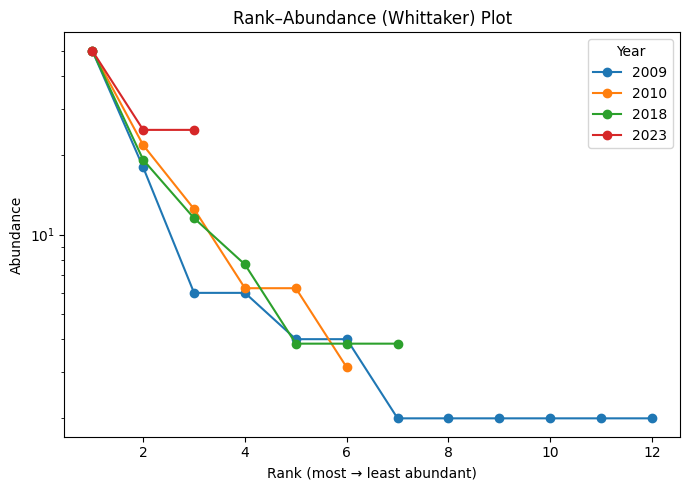

In [7]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2009, 2010, 2018, 2023], log_y=True)